In [1]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2020/lab1-4.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook()

%%latex
\newcommand{\vect}[1]{\mathbf{#1}}
\newcommand{\cnt}[1]{\sharp(#1)}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\softmax}{\operatorname{softmax}}
\newcommand{\Prob}{\Pr}
\newcommand{\given}{\,|\,}

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Course 236299
## Lab 1-4 – Discriminative methods for classification

In this lab, you'll apply a discriminative classification method to the _Federalist_ papers' authorship attribution problem, the logistic regression (perceptron) model. 

After this lab, you should be able to

* Derive the basic equations for the logistic regression classification method;
* Perform the forward computation to generate the class that a logistic regression model predicts for some input;
* Calculate a loss for that prediction, the cross-entropy loss;
* Update the parameters of a logistic regression model by stochastic gradient descent.

New bits of Python used for the first time in the _solution set_ for this lab, and which you may therefore find useful:

* `numpy.exp`

## Preparation – Loading packages and data

In [3]:
# Please do not change these imports because some hidden tests might depend on them.
# You can add a cell below if you need to import anything else.
import json
import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('tableau-colorblind10')
import numpy as np
import os

from math import log2
from pprint import pprint

In [4]:
# Download and read the Federalist data from the json file
shell('wget -nv -N -P data https://github.com/nlp-236299/data/raw/master/Federalist/federalist_data.json')
with open('data/federalist_data.json', 'r') as fin:
    dataset = json.load(fin)

In [5]:
# As before, we extract the papers by either of Madison and Hamilton 
# to serve as training data.
training = list(filter(lambda ex: ex['authors'] in ['Madison', 'Hamilton'],
                       dataset))

## Logistic regression

You've read about logistic regression, a method for classification that is discriminative rather than generative. Like the generative Naive Bayes method, each example is characterized by a vector of features (the counts of word types for a text, say, as for the _Federalist_ example that we've been using). In logistic regression, each such feature is assigned a weight, and the score for an example is given by weighting each feature value by its weight and summing the result; that is, the score is the dot product of the feature vector and the weight vector. Let's take an example, one of the Federalist papers. We'll extract from the training data the counts for the first example in the training set. That's the feature vector for this example.

In [6]:
training0_counts = training[0]['counts']
training0_counts

[9, 6, 2, 0]

Suppose the weights for the features are as given by the following vector:

In [7]:
weights = [-.1, .2, .3, -1]

What would the weighted sum of the counts with these weights be? Feel free to use `np.dot` to take the dot product for you.
<!--
BEGIN QUESTION
name: wtd_sum
-->

In [8]:
#TODO: Take the weighted sum of `training0_counts` with `weights`
w, tr0_c = np.array(weights), np.array(training0_counts)
wtd_sum = np.dot(w, tr0_c)

In [9]:
grader.check("wtd_sum")

All tests passed!

<!-- BEGIN QUESTION -->

**Question:** What is the range of possible values that such a weighted sum can take on?
<!--
BEGIN QUESTION
name: open_response_possible_sums
manual: true
-->

It can be any real number as a multiplication of any real numbers.

<!-- END QUESTION -->

In order to have a standard way of comparing these numbers, it helps to be able to place them on a fixed scale, from 0 to 1, say. This way, they can be interpreted as probabilities. We use the _logistic function_ ($\sigma$) to carry out this conversion:

$$ \sigma(x) = \frac{1}{1 + e^{-k x}}$$

In addition to its argument $x$, the function takes an additional parameter $k$, which we will explore shortly.

Define a function `sigma` implementing the logistic function. (We've established a default value for `k` of 1 in the header line below.)
<!--
BEGIN QUESTION
name: sigma
-->

In [10]:
#TODO: Implement the logistic function
# x can be a number or a numpy array
def sigma(x, k=1):
    return 1/(1+np.exp(-k*x))

In [11]:
grader.check("sigma")

All tests passed!

To get a sense of the logistic function, we graph it for several values of $k$.

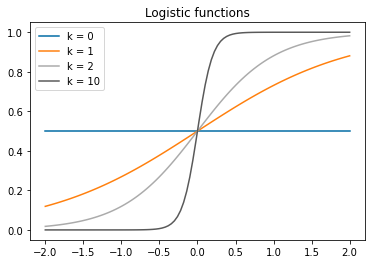

In [12]:
def sigma_plot():
    x = np.linspace(-2, 2, 100)
    fig, ax = plt.subplots()
    for k in [0, 1, 2, 10]:
        ax.plot(x, sigma(x, k), label = f"k = {k}")
    plt.title("Logistic functions")
    plt.legend()
    
sigma_plot()

<!-- BEGIN QUESTION -->

**Question:** What does the $k$ parameter do to the logistic function?
<!--
BEGIN QUESTION
manual: true
name: open_response_k
-->

As we can see from the plot, from a technical (mathematical/geometrical) point of view, it controlls the slope (int terms of absolute value) of the function, i.e the bigger the k, the bigger the slope and the earlier it becomes almost linear near 0 and 1. 
In more meaningfull observations as it can be concluded from the technical observation, k controlls the dicision margins of the clasifier, i.e enlarging k makes more examples to be outliers, i.e enlarging their probability to be classified to the corresponding class ('enlarging' - for the opposite direction of the function towards 0, we can say enlarging about the complementary probability 1-epsilon, for the other class).  

<!-- END QUESTION -->



The logistic function, when applied to the weighted average above is greater than 0.5.

In [13]:
sigma(wtd_sum)

0.710949502625004

In the _Federalist Papers_ classification problem, there are only two classes, so we can use this single value to determine the classification. For an input feature vector $\vect{x}$ and weight vector $\vect{w}$, we'll take the model to predict the probability of the author being Hamilton (say), as

$$\Prob(\mathrm{Hamilton} \given \mathbf{x}) = \sigma(\mathbf{w} \cdot \mathbf{x})$$

Therefore, 

$$\Prob(\mathrm{Madison} \given \mathbf{x}) = 1 - \sigma(\mathbf{w} \cdot \mathbf{x})$$

since there are only two classes.

> When there are more than two classes, we'd use a generalization of the sigmoid function, called [softmax](https://en.wikipedia.org/wiki/Softmax_function).

Define a function `predict_lr` that calculates the probability of **Hamilton** being the author of an example text, given a weight vector and the feature vector for the example text.
<!--
BEGIN QUESTION
name: predict_lr
-->

In [14]:
#TODO: Calculate the probability of Hamilton being the author
def predict_lr(weights, features):
    return sigma(np.dot(weights, features))

This is the _forward computation_ for the logistic regression model, calculating its output prediction from some inputs. Next we turn to the _backward computation_, calculating the updates to the parameters based on any error in the predicted output, as measured by a loss function.

## Using a logistic regression model to predict Federalist authorship

Consider the following two training examples (examples 0 and 9) from the _Federalist_ training dataset:

In [15]:
for example in [0, 9]:
    pprint(training[example])

{'authors': 'Hamilton',
 'counts': [9, 6, 2, 0],
 'number': '1',
 'title': 'General Introduction'}
{'authors': 'Madison',
 'counts': [17, 0, 0, 1],
 'number': '14',
 'title': 'Objections to the Proposed Constitution from Extent of Territory '
          'Answered'}


As above, a logistic regression model is defined by a vector of weights $\mathbf{w}$, like these:

In [16]:
weights

[-0.1, 0.2, 0.3, -1]

Calculate the predicted Hamilton probabilities for the two examples (examples 0 and 9) above.
<!--
BEGIN QUESTION
name: prob_hamilton_examples
-->

In [17]:
#TODO
prob_hamilton_example0 = predict_lr(weights, training[0]['counts'])
prob_hamilton_example9 = predict_lr(weights, training[9]['counts'])

In [18]:
grader.check("prob_hamilton_examples")

All tests passed!

In [19]:
print(f"example 0 prob of Hamilton: {prob_hamilton_example0:.3f}\n"
      f"example 9 prob of Hamilton: {prob_hamilton_example9:.3f}")

example 0 prob of Hamilton: 0.711
example 9 prob of Hamilton: 0.063


<!-- BEGIN QUESTION -->

**Question:** What does this model predict about the two training examples? Is it correct?
<!--
BEGIN QUESTION
name: open_response_original_model_prediction
manual: true
-->

It precits that the probability of the 0-th example to be classified as Hamilton is 0.711, and the probability of the 9-th example to be classified as Hamilton is 0.063, i.e very poor, thus the complementary probability is 1-0.063, is the probability to be classified as 'Madison'. It is correct in both cases.

<!-- END QUESTION -->



## Training a logistic regression model

Of course, this is just one of an infinite number of models (weight vectors), since we could have set the weights in all kinds of ways. How should we come up with a _good_ model, i.e., a good setting of the weights? Ideally, we'd try to find a set of weights that predicts all of the training data well. This is the problem of _training_ a logistic regression model. Let's try another set of weights:

In [20]:
weights_new = [0.1, 0.2, 0.3, -5]

Calculate the probabilities generated by the model for these weights.
<!--
BEGIN QUESTION
name: prob_hamilton_examples_new
-->

In [21]:
#TODO
prob_hamilton_example0_new = predict_lr(weights_new, training[0]['counts'])
prob_hamilton_example9_new = predict_lr(weights_new, training[9]['counts'])

In [22]:
grader.check("prob_hamilton_examples_new")

All tests passed!

In [23]:
print(f"example 0 prob: {prob_hamilton_example0_new:.3f}\n" 
      f"example 9 prob: {prob_hamilton_example9_new:.3f}")

example 0 prob: 0.937
example 9 prob: 0.036


<!-- BEGIN QUESTION -->

**Question:**  Is this a better model, a worse model, or neither, at least as far as the two sample examples are concerned? 
<!--
BEGIN QUESTION
name: open_response_new_model_prediction
manual: true
-->

This model is better, because the predictions is more accurate (93.7% > 71.1% && 96.4% > 93.7%).

<!-- END QUESTION -->



An ideal model would give a probability of 1 to the Hamilton examples and a 0 to the Madison examples.
For the two sample examples, you'll have noticed that the new weights generate not 1 and 0, respectively, but numbers quite a bit closer to 1 and 0.

We could continue trying different weight values to try to improve the performance of the model on these training examples (and others) by trial and error, but a more systematic method is needed. We define a _loss function_, which specifies how bad a model is, and try to minimize the loss function by _stochastic gradient descent_.

We'll do a few steps of the process here by hand. It's sufficiently tedious that it's far better to deploy computers on the task, which we'll do in the next lab.

## Cross-entropy loss function

We'll use the cross-entropy loss function. For an example $i$, we'll use $\mathbf{x}^{(i)}$ for the feature vector, and $y^{(i)}$ for the actual (gold) label (1 or 0, 1 for Hamilton and 0 for Madison). The predicted probability of the label being 1 will be as per the logistic regression model $\sigma(\mathbf{w} \cdot \mathbf{x}^{(i)})$, which we will call $\hat{y}^{(i)}$.

The cross-entropy loss for example $i$ as per a model $\mathbf{w}$ is
$$L_{CE}(\mathbf{w}) = -(y^{(i)} \log \hat{y}^{(i)} + (1-y^{(i)}) \log (1-\hat{y}^{(i)}))$$



<!-- BEGIN QUESTION -->

**Question:** What is the minimum possible value of the cross-entropy loss above? When is that achieved?
<!--
BEGIN QUESTION
name: open_response_ce_loss
manual: true
-->

The minimal possible value is 0.


<!-- END QUESTION -->

Define a function to compute the cross-entropy loss for a particular model (weight vector), example (feature vector), and gold label:
<!--
BEGIN QUESTION
name: loss
-->

In [24]:
#TODO: define the cross-entropy loss function according to the equation above. The output should be a scalar loss.
def loss(weights, features, correct):
    """Returns the cross-entropy loss for a weight vector, a feature
       vector and a gold label `correct`."""
    y_hat = predict_lr(weights,features)
    loss = -(correct*math.log2(y_hat)+(1-correct)*math.log2(1-y_hat))
    return loss

In [25]:
grader.check("loss")

All tests passed!

Use the `loss` function to determine the cross-entropy loss for example 0 for the original model that we used (`weights`), and for the new model (`weights_new`).
<!--
BEGIN QUESTION
name: loss_example0_old_and_new
-->

In [26]:
#TODO: Calculate loss for training[0] under `weights` and `weights_new`

loss_example0_old = loss(weights, training[0]['counts'], training[0]['authors']=='Hamilton')
loss_example0_new = loss(weights_new, training[0]['counts'], training[0]['authors']=='Hamilton')

In [27]:
grader.check("loss_example0_old_and_new")

All tests passed!

In [28]:
print(f"Old model loss: {loss_example0_old:.3f}\n"
      f"New model loss: {loss_example0_new:.3f}")

Old model loss: 0.492
New model loss: 0.094


<!-- BEGIN QUESTION -->

**Question:** Which of the models is better (at least on this example)?
<!--
BEGIN QUESTION
name: open_response_loss_on_example
manual: true
-->

the new model is better (as expected by previous accuracy estimations), it's loss is much lesser then the old's model.

<!-- END QUESTION -->



## Gradient of the loss function

We want to find the weights that minimize the loss function. We use gradient descent:

1. Find the gradient of the loss function, the direction in which it is increasing fastest.
2. Take a step in the opposite direction.
3. Repeat.

For cross-entropy loss, recall that the partial derivative of the loss function with respect to a single weight $w_j$ is

$$ \frac{\partial L_{CE}(\mathbf{w})}{\partial w_j} = (\hat{y} - y) x_j $$

> At the end of this subsection, we give a problem that explores how this gradient is derived, but you can just assume it for the time being.

The gradient combines these partial derivatives for all of the weights.

$$ \nabla L_{CE}(\mathbf{w}) = \left[ \begin{array}{c}
    \frac{\partial L_{CE}(\mathbf{w})}{\partial w_1}\\
    \frac{\partial L_{CE}(\mathbf{w})}{\partial w_2}\\
    \vdots \\
    \frac{\partial L_{CE}(\mathbf{w})}{\partial w_m}
    \end{array} \right] $$

Let's work out an example, using example 0. The counts for example 0 are

In [29]:
training[0]['counts']

[9, 6, 2, 0]

and the original weights, recall, were

In [30]:
weights

[-0.1, 0.2, 0.3, -1]

What is the gradient vector for these `weights` and training example `training[0]`?
<!--
BEGIN QUESTION
name: grad_vector
-->

In [31]:
y_hat = predict_lr(weights, training[0]['counts'])
grad_vector = np.dot((y_hat-(training[0]['authors']=='Hamilton')), training[0]['counts'])
grad_vector

array([-2.60145448, -1.73430298, -0.57810099,  0.        ])

In [32]:
grader.check("grad_vector")

All tests passed!

## Adjusting weights against the gradient

Step 2 is to adjust the weights in the _opposite_ direction of the gradient.
In this case, we compute the new weight vector $w'$ by adding to the weight vector a fraction of the negative gradient:

$$ \mathbf{w}' = \mathbf{w} - \eta \nabla L_{CE}(\mathbf{w}) $$

Here, $\eta$ is the _learning rate_. The larger $\eta$ is, the more we move in each step, but if $\eta$ is too large we risk overshooting. We'll use a learning rate of 0.1 for now. (Setting good learning rates is one aspect of the black arts of machine learning.)

In [33]:
learning_rate = 0.1

Calculate the new weight vector using `learning_rate` and `grad_vector`.
<!--
BEGIN QUESTION
name: weights_updated
-->

In [34]:
weights_updated = weights-learning_rate*grad_vector

In [35]:
grader.check("weights_updated")

All tests passed!

In [36]:
pprint(weights_updated)

array([ 0.16014545,  0.3734303 ,  0.3578101 , -1.        ])


How do these weights perform on the training example we've been using? Let's see.

In [37]:
loss_example0_updated = loss(weights_updated, training[0]['counts'], training[0]['authors']=='Hamilton')

In [38]:
print(f"Old model loss: {loss_example0_old:.3f}\n"
      f"New model loss: {loss_example0_new:.3f}\n"
      f"Updated model loss: {loss_example0_updated:.3f}")

Old model loss: 0.492
New model loss: 0.094
Updated model loss: 0.018


If you did this all right, the loss for the updated model, which was generated by taking a single step opposite the gradient from the old model is not only better than the old model, but better than the new model we used above as well. 

What about the loss on the other example we've been using (example 9)? Calculate the loss for example 9 with the old model (`weights`), the new model (`weights_new`), and the updated model (`weights_updated`):
<!--
BEGIN QUESTION
name: weights_updated_9
-->

In [39]:
#TODO
loss_example9_old = loss(weights, training[9]['counts'], training[9]['authors']=='Hamilton')
loss_example9_new = loss(weights_new, training[9]['counts'], training[9]['authors']=='Hamilton')
loss_example9_updated = loss(weights_updated, training[9]['counts'], training[9]['authors']=='Hamilton')

In [40]:
grader.check("weights_updated_9")

All tests passed!

In [41]:
print(f"Old model loss: {loss_example9_old:.3f}\n"
      f"New model loss: {loss_example9_new:.3f}\n"
      f"Updated model loss: {loss_example9_updated:.3f}")

Old model loss: 0.094
New model loss: 0.052
Updated model loss: 2.722


<!-- BEGIN QUESTION -->

**Question:** Did the update to the model improve its performance on example 9 or make it worse? Why?

<!--
BEGIN QUESTION
name: open_response_updated_9
manual: true
-->

It made it worse because the gradient that minimize one concrete example  of the dataset, in our case example 0 for which we used the loss optimization step, not necessarily and even probably not minimize the loss for another examples (it could happen only if all the examples are very similiar). To achieve this we should use gradient step methods which take a look on a few examples, as mini-batch gradient descent algorithm. It is guaranteed that for all seen examples, for a small enough step and if we are not ocassionaly allready in the optimum, the the loss optimization step will improve the loss for each just seen example. 


<!-- END QUESTION -->



## Repeating the process

Step 3 is to repeat the process for this and other training examples. We could recalculate the gradient and take another step to improve further, and take steps to improve the other training examples, and so on and so forth, eventually converging on a model that works well over the entire training set. But doing so manually in this way is too tedious. We need to be able to do these kinds of computations at scale. Fortunately, in the next lab we'll be turning to packages that allow specifying these larger-scale computations.

<!-- BEGIN QUESTION -->

## Optional Questions
The following questions are **optional**, you don't have to submit them.

### Optional Question #1 ###
In the figure of the logistic function, the logistic function looks to be radially symmetric. In particular, it appears that $\sigma(x) = 1 - \sigma(-x)$. (If so, we can use a simple thresholding for classificiation purposes, $\sigma(x) > 0.5$ to capture $x > 0$.)

Prove the identity $\sigma(x) = 1 - \sigma(-x)$.

<!--
BEGIN QUESTION
manual: true
name: open_response_sigma_identity
-->

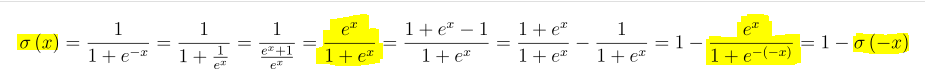

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Optional Question #2 - Deriving the gradient of the cross-entropy loss


Jurafsky and Martin provide a derivation for the cross-entropy loss in their section 5.8. There, they note that the derivation relies on the salutary fact that the derivative of the sigmoid has an especially simple form:

$$ \frac{d \sigma(z)}{dz} = \sigma(z) \cdot (1 - \sigma(z)) $$

**Question:** Prove this identity.

> **Hint:** You may find some of the following standard formulas for the derivative of various functions – reviewed from your calculus course – useful. (In these schematic identities, $u$ and $v$ are metavariables over functions of $z$, and $a$ and $n$ are metavariables over constants.)


\begin{align*}
\frac{d}{dz} a &= 0 \\
\frac{d}{dz} (u + v) &= \frac{du}{dz} + \frac{dv}{dz} \\
\frac{d}{dz} (u\,v) &= v\frac{du}{dz} + u\frac{dv}{dz} \\
\frac{d}{dz} \left[\frac{1}{u}\right] &= - \frac{1}{u^2} \frac{du}{dz} \\
\frac{d}{dz} u^n &= n u^{n-1} \frac{du}{dz} \\
\frac{d}{dz} e^u &= e^u \frac{du}{dz} \\
\frac{d}{dz} \log_a u &= (\log_a e) \frac{1}{u} \frac{du}{dz} 
\end{align*}


<!--
BEGIN QUESTION
manual: true
name: open_response_sigmoid_gradient
-->

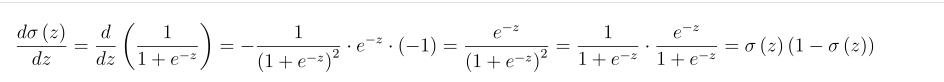

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Lab debrief – for consensus submission only

**Question:** We're interested in any thoughts your group has about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following: 

* Was the lab too long or too short?
* Were the readings appropriate for the lab? 
* Was it clear (at least after you completed the lab) what the points of the exercises were? 
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# End of lab 1-4

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [42]:
grader.check_all()

grad_vector:

    All tests passed!
    

loss:

    All tests passed!
    

loss_example0_old_and_new:

    All tests passed!
    

prob_hamilton_examples:

    All tests passed!
    

prob_hamilton_examples_new:

    All tests passed!
    

sigma:

    All tests passed!
    

weights_updated:

    All tests passed!
    

weights_updated_9:

    All tests passed!
    

wtd_sum:

    All tests passed!